# Demonstration Notebook

This notebook contains several use cases demonstrating data exploration, manipulation of the model variables, estimation and model selection. It is meant to familiarize the user with important functions and notations used throughout the code. It is divided into three sections:

- [1) Data and Model Variables](#S1)
- [2) Model Estimation](#S2)
- [3) Model Selection](#S3)

Some sections are marked with a star (*), and can be skipped without harming the understanding of the remainder.

The results for time-consuming operations are pre-computed, and can be imported easily to save energy and computation time. The cells preceding these operations are marked with the tag <b style="color:green">[Pre-computed]</b>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import src_exp.model
import src_exp.saem
import src_base.mcmc
import src_base.selection
import src_common.plotting
import src_common.utils

# Fix all random seeds
src_common.utils.set_random_seed(1)

# Silence Numba warnings
import warnings
from numba.core.errors import NumbaPerformanceWarning
warnings.simplefilter("ignore", category=NumbaPerformanceWarning)

def load_computation(file_name):
    """Loads the result of a computation stored in a pickle file."""
    f = open(file_name, mode="rb")
    content = pickle.load(f)
    f.close()
    return content

## 1) Data and Model Variables <a id="S1"></a>

In this notebook, we consider the toy data set stored in `data/test.pkl`. 

In [2]:
f = open("data/test.pkl", mode="rb")
y, t, z, theta = pickle.load(f) # All synthetic data files that can be generated by the code are stored in this format
f.close()

### 1.A) The Data: `y` and `t`

- `y` is the collection of all observations of each individual. For instance, `y[2]` contains the list of (vector-valued) measurements for individual 2.

In [3]:
obs = y[2]
print(obs) # may contain missing data

[[-1.84075193 -2.57736492]
 [ 1.04650026 -2.44340628]
 [ 0.88754844 -0.44818031]
 [ 1.35776445 -0.50766888]
 [ 2.75639985  3.73720591]
 [ 2.74556671  6.847359  ]
 [ 3.38782144  8.37176317]
 [ 4.29349302  8.16548165]
 [ 3.39721669 10.94494306]
 [ 5.23386811 10.32572706]]


In this data set, the data has dimension 2: 

In [4]:
d = len(y[0][0])

- Similarly, `t` contains the collection of observation times: `t[2]` contains the list of dates of each measurement for individual 2.

In [5]:
print(t[2])

[-7.1037896  -5.81807531 -4.53236103 -3.24664674 -1.96093246 -0.67521817
  0.61049611  1.8962104   3.18192469  4.46763897]


The series measurements for one or several individuals can be visualized as follows.

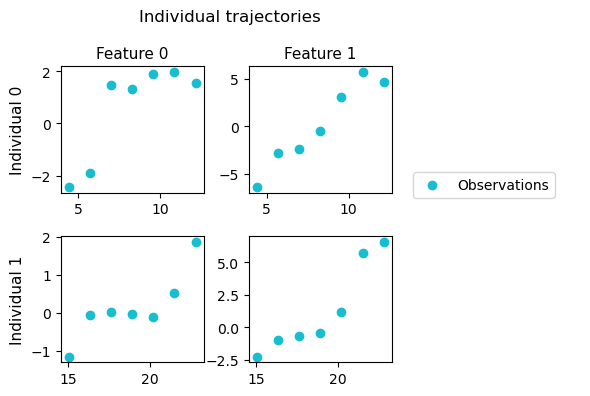

In [6]:
indices = [0, 1] # plot the individuals number 0 and 1
src_common.plotting.plot_individual_trajectories(y, t, indices=indices)

### 1.B) The Model Variables: `theta` and `z`

- `theta` and `z` are, respectively, the true value of the model parameters and the latent variable used to generate the synthetic data.

Both `theta` and `z` are tuples, which can be expanded. Let us start with `theta`:

In [7]:
p0_bar, t0_bar, v0_bar, sigma_xi, sigma_tau, sigma_psi, sigma = theta

The first three parameters `p0_bar`, `t0_bar` and `v0_bar` define the shape of the population trajectory:
- `p0_bar` is the list of trajectory values at the first break,
- `t0_bar` is the list of break times,
- `v0_bar` is the list of slopes for each coordinate and each piece of the trajectory.

`v0_bar` thus has $K+1$ components, with $K$ the number of breaks in the trajectory.

In [8]:
K = len(v0_bar) - 1 # number of breaks in the population trajectory

The population trajectory can be visualized simply:

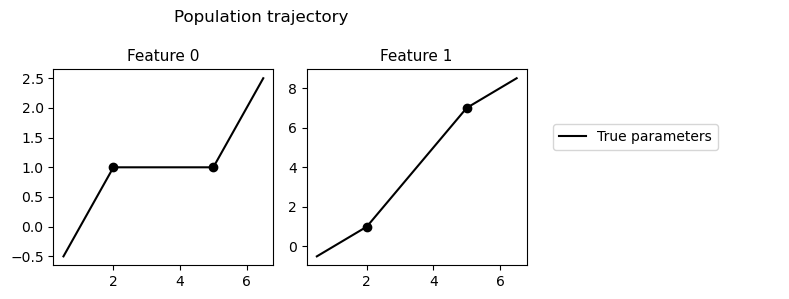

In [9]:
src_common.plotting.plot_population_trajectories(Theta=[theta], labels=["True parameters"])

We will focus later on `sigma_xi`, `sigma_tau` and `sigma_psi`. The remaining parameter `sigma` represents the standard deviation of the noise on the observed data on each component. In our model, we consider the noise to be heteroscedastic with independent components.

In [10]:
print(sigma)

[0.8 1.2]


Let us now look at the latent variable `z`. By convention, in all the synthetic data files generated by the code, the latent variable is stored in the form of the exponentialized model. It reads as follows:

In [11]:
p0, t0, v0, tau, xi, psi = z

The first three components `p0`, `t0` and `v0` are twin variables of the model parameters `p0_bar`, `t0_bar` and `v0_bar` ; they are used as a computational trick to estimate the model parameters with the MCMC-SAEM algorithm.

The three remaining variables `tau`, `xi` and `psi` represent, for each individual, how its trajectory deviates from the average. For an individual `i`:
- `tau[i]` gives a temporal shift between individual `i` and the population trajectory. More precisely, `tau[i]` is the time difference between the first break in the population trajectory and the first break in the trajectory of the individual.
- `xi[i,j]` represents the logarithmic acceleration factor of individual `i` on the piece `j` of the trajectory. More precisely, `np.exp(xi[i,j])` gives, for the `j`-th piece of the trajectory, the ratio between the slopes of the individual trajectory and the population trajectory.
- `psi[i,k]` is the difference between the value of the population trajectory at its first break and the the value of the trajectory of individual `i` at its first break, on coordinate `k`. In other words, `psi[i]` is the spatial shift between the population trajectory and the individual trajectory.

The parameters `sigma_xi`, `sigma_tau` and `sigma_psi` control the standard deviations of the related latent variables. As with `sigma`, the noise on `xi` and `psi` is assumed to be heteroscedastic with independent components.

The individual trajectory parameterized by `z` can be visualized very simply along with the observations:

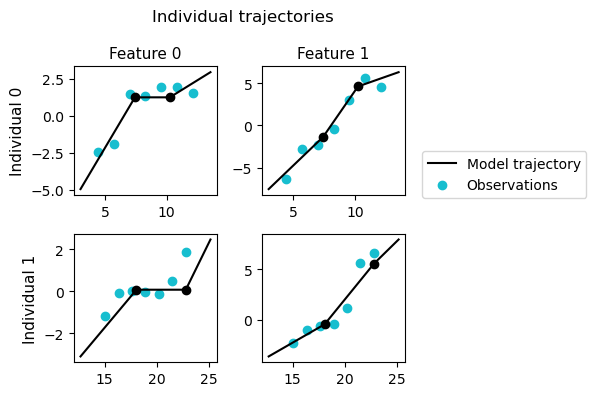

In [12]:
indices = [0, 1] # plot the trajectories for individuals number 0 and 1
src_common.plotting.plot_individual_trajectories(y, t, indices=indices,
                                                 Theta=[theta], Z=[z], labels=["Model trajectory"])

Knowing the detailed expressions of `theta` and `z` is not required to run the code, but it helps understanding its results. As an example, the function `src_exp.model.occupation_rates` gives the percentage of observed data that fall in each piece of the population trajectory:

In [13]:
occupations = src_exp.model.occupation_rates(t, z, theta)
for k in range(len(occupations)):
    print(f"Piece {k+1} contains {100*occupations[k]:.1f}% observations")

Piece 1 contains 39.1% observations
Piece 2 contains 35.3% observations
Piece 3 contains 25.6% observations


### 1.C) Useful Functions and Variables (*)

*This section dwells on internal mechanics of the code, and can be skipped without harm.*

The modules `src_exp.model` (or  equivalently `src_base.model` for the base model) contain many useful functions to manipulate the variables, compute trajectories and likelihoods. These functions are used extensively throughout the code. We introduce a few of them for the interested reader ; most other functions rely on the same conventions and variables.

**Variable manipulation** The variable `z` can be stored in two other alternative formats:

In [14]:
z_vect = src_exp.model.pack_z(z) # z_vect packs z into a large vector
z_full = src_exp.model.get_z_full(z) # z_full is an enriched version of z (see below)

# z can be recovered from z_vect, but the process requires d (data dimension) and K (number of breaks in the trajectory)
z = src_exp.model.unpack_z(z_vect, d=d, K=K)

Depending on the function, a different variant of `z` may be asked in input. The name of the function argument corresponds to the required variant: for instance, the function `src_exp.model.D_i` (introduced below) has signature `D_i(z_full, i, time)`, and it thus takes `z_full` as input.

Just like `z`, the variable `z_full` can be expanded as into a tuple:

In [15]:
ps0, t0, v0, taus, xi, psi = z_full

In this tuple:
- `ps0` replaces `p0`: it is the list of all trajectory breakpoints positions. In particular, `p0` is stored in `ps0[0]`.
- `taus` replaces `tau`: `taus[i]` is the list of all time shifts between the breaks of the population trajectory and the breaks in the trajectory of individual `i`.

The other components (`t0, v0, xi, psi`) match with those in `z`. Alternatively, `ps0` can be obtained with `src_exp.model.get_breakpoint_positions` and `taus` with `src_exp.model.get_taus`.

As with `z`, `theta` can also be packed into a vector and unpacked:

In [16]:
theta_vect = src_exp.model.pack_theta(theta)
theta = src_exp.model.unpack_theta(theta_vect, d=d, K=K)

**Trajectory computation** The functions `src_exp.model.D` and `src_exp.model.D_i` can be used, respectively, to compute the value of the population trajectory and individual trajectories.

In [17]:
# Let us compute the value of the population trajectory at time t=10:
time = 10
print(f"Population trajectory at time t={time}:", src_exp.model.D(ps0, t0, v0, time))

# Now, let us compute the value of the trajectory of individual number 2 at the same point in time:
i = 2
print(f"Position of individual {i} at time t={time}:", src_exp.model.D_i(z_full, i, time).round(2))

Population trajectory at time t=10: [ 6. 12.]
Position of individual 2 at time t=10: [10.49 15.64]


**Likelihood computation** Various functions in `src_exp.model` compute expressions of the model likelihood. As an example, the function `src_exp.model.log_lk` computes $\log p(y, z\mid \theta)$, i.e., the complete likelihood of the latent variable and the observed data.

First, we need to define the prior on the model parameters. The function `src_exp.model.get_prior` gives a ready-made prior for the exponential model, adapted to the scale of the synthetic data.

In [18]:
K = v0.shape[0]-1 # number of breaks in the population trajectory
d = v0.shape[1]   # data dimension
prior = src_exp.model.get_prior(K=K, d=d)

The function `log_lk` is compiled with the package `numba` to decrease the computation time. As a consequence, it cannot take `y` and `t` as argument: they must first be converted into numpy arrays representations, `y_mat` and `t_mat`.

In [19]:
# Convert y and t to numpy arrays
y_mat = src_common.utils.get_y_mat(y)
t_mat = src_common.utils.get_t_mat(t)

We can now compute the log-likelihood:

In [20]:
# Since y_mat and t_mat are rectangular arrays, the function log_lk
# additionally needs to know the number of observations for each individual
n = np.array([len(y[i]) for i in range(len(y))])

log_likelihood = src_exp.model.log_lk(y_mat, t_mat, n, z_vect, theta, prior)
print(f"log p(y,z|theta) = {log_likelihood:.2f}")

log p(y,z|theta) = -4130.40


Similarly, the function `src_exp.model.log_lk_full` computes $\log p(y, z, \theta)$:

In [21]:
log_likelihood_full = src_exp.model.log_lk_full(y_mat, t_mat, n, z_vect, theta, prior)
print(f"log p(y,z,theta) = {log_likelihood_full:.2f}")

log p(y,z,theta) = -4132.14


## 2) Model Estimation <a id="S2"></a>

### 2.A) Estimation algorithm

In applications, the optimal model parameters are not known, and must be estimated. In this project, we use the MCMC-SAEM algorithm to compute the Maximum A Posteriori (MAP) estimator. The estimator solves the optimization problem:
$$
\max_\theta \log p(y, \theta) = \max_\theta \log p(\theta) + \log p(y \mid \theta) = \max_\theta \log p(\theta) + \log \int_z p(y, z \mid \theta)~\!\mathrm d z\,.
$$

First, **we need to define the prior** $p(\theta)$ on the model parameters. The function `src_exp.model.get_prior` gives the parameters for a ready-made prior for the exponential model, adapted to the scale of the synthetic data.

In [22]:
K = v0.shape[0] - 1 # desired number of breaks in the population trajectory
d = v0.shape[1]   # data dimension
prior = src_exp.model.get_prior(K=K, d=d)

<b style="color:green">[Pre-computed]</b> Once the prior is defined, all it takes to run the estimation algorithm and compute the MAP is one line:

In [ ]:
# 100K is the typical number of iterations to approach convergence
z_map, theta_map, history = src_exp.saem.MCMC_SAEM(y, t, prior, n_iter=100000, track_history=500)

The argument `n_iter` is the number of steps to be used in the algorithm. The argument `track_history` controls the proportion of iterates saves in the return variable `history`. More precisely:
- If `track_history` is an integer, the function saves a copy of the `z` and `theta` every `track_history` SAEM steps.
- If `track_history = False`, no track of the history is stored.

Alternatively, we directly provide the estimation result to save time:

In [23]:
z_map, theta_map, history = load_computation("demo/estimation_K2.pkl")

Let us visualize the convergence of the algorithm, comparing with the ground truth:

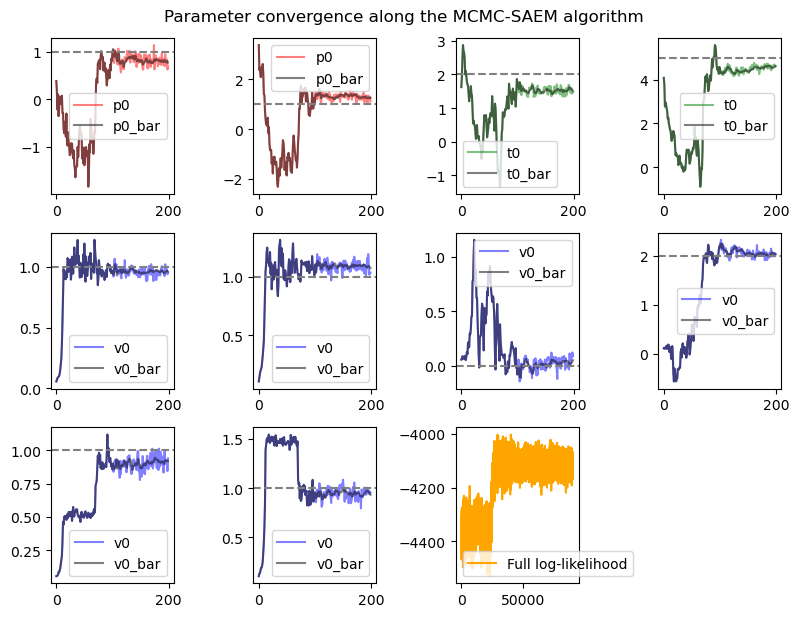

In [24]:
src_common.plotting.plot_convergence(history, d=d, K=K, true_theta=theta)

**Remark** Although it is the case here, the sequence given by `history["log_likelihood"]` may not always be increasing, even on average (see the documentation of `src_exp.saem.MCMC_SAEM`).

### 2.B) Comparing the results

Once the results are obtained, we want to investigate the estimation quality:
- Are the parameters well estimated?
- Does the estimated population trajectory look like the true trajectory?
- How well is the trajectory of each individual reconstructed?

**Parameter estimation** The distance between the estimation `theta_map` and the ground truth `theta` can be measured in terms of relative errors with the function `src_common.utils.compare_thetas`.

In [25]:
variable_names = ["p0_bar", "t0_bar", "v0_bar", "sigma_xi", "sigma_tau", "sigma_psi", "sigma"]
comparison = src_common.utils.compare_theta(theta_map, theta)

for k in range(len(comparison)):
    spaces = 10-len(variable_names[k])
    print(f"Relative error on {variable_names[k]}:"+spaces*" "+f"{round(100*comparison[k],2)}%")

Relative error on p0_bar:    25.53%
Relative error on t0_bar:    11.32%
Relative error on v0_bar:    5.26%
Relative error on sigma_xi:  10.0%
Relative error on sigma_tau: 0.42%
Relative error on sigma_psi: 1.71%
Relative error on sigma:     2.29%


**Population trajectory** Using `src_common.plotting`, the estimation of the population trajectory can be easily compared with the ground truth:

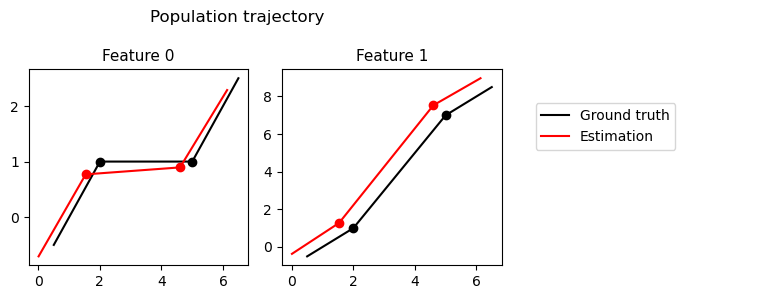

In [26]:
src_common.plotting.plot_population_trajectories(Theta=[theta, theta_map], labels=["Ground truth", "Estimation"])

**Individual trajectories** Similarly, the estimation of the individual trajectories can be compared to the ground truth. However, we first need to choose the value of the latent variable $z$ used to build the reconstruction. An interesting choice is the posterior mean of $z$ given $y$ and $\theta$: $z_{\mathrm{posterior}} = \mathbb E[z \mid y, \theta_{\mathrm{MAP}}]$.

<b style="color:green">[Pre-computed]</b> The posterior mean `z_posterior` is computed with MCMC in the framework of the base model:

In [ ]:
# First, we define a starting point for the MCMC by using the final value of z given by the MCMC-SAEM algorithm
p0_map, t0_map, v0_map, tau_map, xi_map, psi_map = z_map
# In the base model, the latent variable only contains tau, xi and psi:
z_init = tau_map, xi_map, psi_map

# Now, we run the MCMC starting from z_init
n_iter = 10000
z_posterior = src_base.mcmc.posterior_z_mean(y, t, z_init, theta_map, n_iter=n_iter)

Or alternatively directly import the result of the computation:

In [27]:
z_posterior = load_computation("demo/z_posterior_K2.pkl")

**Remark:** provided a `multiprocessing.Pool` object, the function `src_base.mcmc.posterior_z_mean` can use parallelism to compute the variables of each individual in a separate process.

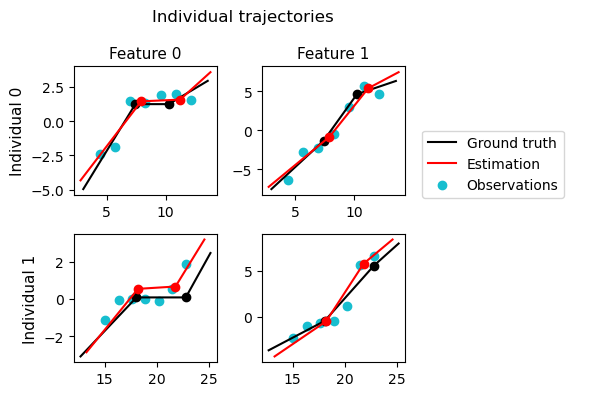

In [28]:
src_common.plotting.plot_individual_trajectories(
    y, t, indices=indices, Z=[z, z_posterior],
    Theta=[theta, theta_map], labels=["Ground truth", "Estimation"])

## 3) Model Selection <a id="S3"></a>

We are interested in selecting the best value for the number of breaks $K$. This is done by estimating the parameters of each candidate models, and grading each model with an information criterion (AIC, BIC, etc.).

### 3.A) Computing the marginal likelihood

We use information criteria relying on the marginal likelihood of the observed data, i.e., $\log p(y\mid \theta) = \log \int_z p(y, z \mid \theta)~\!\mathrm d z $. We estimate this quantity using Bridge Sampling, a Monte-Carlo method similar to Importance Sampling.

The Bridge Sampling algorithm relies on a MCMC on the latent variable in the base model. As with the posterior mean, we need to provide a relevant starting point to the MCMC. Similarly, wee build the base model latent variable by removing `p0`, `t0` and `v0` from the exponential model latent variable `z_map`.

<b style="color:green">[Pre-computed]</b> The marginal likelihood is computed as follows:

In [ ]:
z_init = tau_map, xi_map, psi_map

marginal_likelihood, error_estimate = src_base.selection.compute_marginal_likelihood(
                y, t, z_init, theta_map, n_iter=100000)

Alternatively, the result is given here:

In [29]:
marginal_likelihood = -3903.8028363694275
error_estimate      = 1.0855162188117804

---

In [30]:
print(f"Marginal likelihood estimation: {marginal_likelihood:.2f} (+/- {error_estimate:.2f})")

Marginal likelihood estimation: -3903.80 (+/- 1.09)


Using this marginal likelihood, several information criteria can be estimated:
- The Akaike Information Criterion: $AIC = 2\dim(\theta) - 2\log p(y\mid \theta)$,
- The Bayesian Information Criterion: $BIC = \log(N)\dim(\theta) - 2\log p(y\mid \theta)$,
- The hybrid BIC for mixed effects models: $BIC_h = \log \left(\sum_i n_i\right) \dim (\theta_F) + \log(N) \dim(\theta_R)$ (see Delattre et al. 2014),

with the notations:
- $N$ the number of individuals,
- $n_i$ the number of observations for individual $i$,
- $\theta_F$ the fixed effects parameters and $\theta_R$ the random effects parameters.

These criteria can be computed simply:

In [31]:
K = len(v0) - 1  # number of breaks in the population trajectory
d = len(y[0][0]) # data dimension
N = len(y)       # number of individuals
n = np.array([len(y[i]) for i in range(len(y))]) # n[i] = number of observations for individual i

AIC   = src_base.selection.AIC(marginal_likelihood, K=K, d=d)
BIC   = src_base.selection.BIC(marginal_likelihood, K=K, d=d, N=N)
BIC_h = src_base.selection.BIC_hybrid(marginal_likelihood, K=K, d=d, N=N, n=n)

print("AIC   ", round(AIC, 2))
print("BIC   ", round(BIC, 2))
print("BIC_h ", round(BIC_h, 2))

AIC    7845.61
BIC    7902.81
BIC_h  7923.82


Then, we can select the model with the smallest value for a given information criterion.

### 3.B) Selecting the best model

Let us now test whether adding one more break to the trajectory gives a better model.

In [32]:
K_new = K + 1

<b style="color:green">[Pre-computed]</b> We estimate the parameters of the new model...

In [ ]:
prior_new = src_exp.model.get_prior(K=K_new, d=d)
z_new, theta_new, history_new = src_exp.saem.MCMC_SAEM(y, t, prior_new, n_iter=100000, track_history=500)

...or directly read the estimation result...

In [33]:
z_new, theta_new = load_computation("demo/estimation_K3.pkl")

<b style="color:green">[Pre-computed]</b> ...and we compute its marginal likelihood:

In [ ]:
z_init = z_new[3:]

marginal_likelihood_new, error_estimate_new = src_base.selection.compute_marginal_likelihood(
                y, t, z_init, theta_new, n_iter=100000)

Alternatively, the result is given here:

In [34]:
marginal_likelihood_new = -3904.4655827050374
error_estimate_new      = 1.1768977196680082

---

In [35]:
print(f"New marginal likelihood: {marginal_likelihood_new:.2f} (+/- {error_estimate_new:.2f})")

New marginal likelihood: -3904.47 (+/- 1.18)


We deduce the information criteria:

In [36]:
AIC_new   = src_base.selection.AIC(marginal_likelihood_new, K=K_new, d=d)
BIC_new   = src_base.selection.BIC(marginal_likelihood_new, K=K_new, d=d, N=N)
BIC_h_new = src_base.selection.BIC_hybrid(marginal_likelihood_new, K=K_new, d=d, N=N, n=n)

print(f"         K={K}        K={K_new}")
print(f"AIC    {round(AIC,   2):.2f}    {round(AIC_new,   2):.2f}")
print(f"BIC    {round(BIC,   2):.2f}    {round(BIC_new,   2):.2f}")
print(f"BIC_h  {round(BIC_h, 2):.2f}    {round(BIC_h_new, 2):.2f}")
print("\n   (smaller is better)")

         K=2        K=3
AIC    7845.61    7854.93
BIC    7902.81    7924.18
BIC_h  7923.82    7950.92

   (smaller is better)


**Conclusion:** for all three information criteria, the model with $K=2$ breaks outperforms the model with $K=3$ breaks, which does not significantly improve the marginal likelihood.

### 3.C) Uncertainty on the slopes (*)

*This section contains a discussion on an alternate criterion to investigate the selection of $K$; it can be skipped without harm.*

**Problem** Selecting the best number of breaks is a difficult problem, and taking a decision based on a sole information criterion may provide a flawed perspective, in especially when the number of individuals is small. In this setting (typically 50 individuals of fewer), the uncertainty on the trajectory parameters becomes non-negligible, and the performance of information criteria degrades accordingly. In particular, the uncertainty on the speed vectors $v_k$ and $v_{k+1}$ may be so large that the two pieces of the trajectory do not significantly differ.

**Idea** We thus want a way to compare $v_k$ and $v_{k+1}$ up to uncertainty. We propose to achieve this by computing the Mahalanobis norm $D_k = \mu_k \Sigma_k^{-1} \mu_k$, with $\mu_k = \mathbb E[v_{k+1} - v_k \mid y, \theta]$ and $\Sigma_k = \mathrm{Cov}[v_{k+1} - v_k \mid y, \theta]$. These means and covariances can be computed simply, by running a joint MCMC over the individual latent variables `z` and the parameter `v0`. The metric $D_k$ measures the distance between $v_k$ and $v_{k+1}$, taking into account the geometry induced by the covariance matrix $\Sigma_k$. This covariance may affect the result: if it is very stretched along the direction $v_{k+1} - v_k$, then the slope vectors $v_k$ and $v_{k+1}$ are harder to distinguish.

<b style="color:green">[Pre-computed]</b> Let us apply this method on the model with $K=3$ breaks of the last section. The joint MCMC on `z` and `v0` is performed with `src_base.mcmc.mh_v0`:

In [ ]:
N_small = 50 # Keep only the first 50 individuals to increase the uncertainty on v0

y_mat = src_common.utils.get_y_mat(y[:N_small])
t_mat = src_common.utils.get_t_mat(t[:N_small])

# Pack the base model latent variable
_, _, _, tau_new, xi_new, psi_new = z_new
z_vect_new = src_base.model.pack_z((tau_new[:N_small], xi_new[:N_small], psi_new[:N_small]))

# Define the prior for the base model
prior_base = src_base.model.get_prior(K=K_new, d=d)

# First blank run with only one iteration, for numba compilation
n = np.array(list(map(len, y[:N_small])))
src_base.mcmc.mh_v0(y_mat, t_mat, n, z_vect_new, theta_new, prior_base, n_iter=1, prop=(1e-2, 1e-2))

# Second run, now with a larger number of iterations
result, _, _ = src_base.mcmc.mh_v0(y_mat, t_mat, n, z_vect_new, theta_new,
                                   prior_base, n_iter=50000, prop=(1e-2, 1e-2))

Alternatively, the result can be retrieved below.

In [37]:
result = load_computation("demo/mcmc_v0_K3.pkl")

We can now compute the similarity matrix, which gives the covariance-rescaled distance between all pairs of slope vectors:

In [38]:
similarity_matrix = np.zeros((result.shape[1], result.shape[1]))
inv = np.linalg.inv
for i in range(result.shape[1]):
    for j in range(result.shape[1]):
        if i != j:
            C = np.cov((result[:,i,:]-result[:,j,:]).T)
            mi = result[:,i,:].mean(axis=0)
            mj = result[:,j,:].mean(axis=0)
            similarity_matrix[i,j] = (mi-mj)@inv(C)@(mi-mj)/2

print(similarity_matrix)

[[ 0.         28.84610208  0.98766289  1.1101554 ]
 [28.84610208  0.          0.94134293 22.33298367]
 [ 0.98766289  0.94134293  0.          0.94434162]
 [ 1.1101554  22.33298367  0.94434162  0.        ]]


In particular, the similarity matrix gives the covariance-rescaled distance between consecutive pieces:

In [39]:
print("Rescaled distance between slopes on pieces:")
for k in range(result.shape[1]-1):
    print(f"Pieces {k+1} and {k+2}: {similarity_matrix[k,k+1]:.2f}")

Rescaled distance between slopes on pieces:
Pieces 1 and 2: 28.85
Pieces 2 and 3: 0.94
Pieces 3 and 4: 0.94


We can see that, up to uncertainty, **the pieces 2 and 3 are hard to distinguish, and same with the pieces 3 and 4**. Let us look at the shape of the population trajectory:

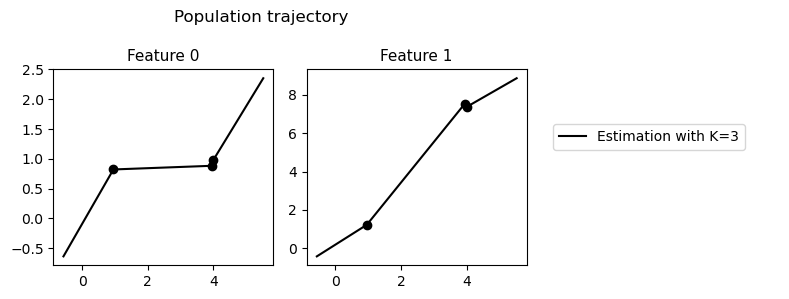

In [40]:
src_common.plotting.plot_population_trajectories(Theta=[theta_new], labels=["Estimation with K=3"])

We can see that the third piece is very short. It also contains very few observations, as can be seen with `src_exp.model.occupation_rates`:

In [41]:
occupations = src_exp.model.occupation_rates(t, z_new, theta_new)
for k in range(K_new+1):
    print(f"Piece {k+1} contains {100*occupations[k]:.1f}% observations")

Piece 1 contains 40.5% observations
Piece 2 contains 32.9% observations
Piece 3 contains 0.6% observations
Piece 4 contains 26.1% observations


**Since the third piece only contains 0.6% of the observations, its slope vectors naturally have a very high uncertainty.** The covariance-rescaled similarity scores reflect this uncertainty. Similarity scores and occupation rates are easy to use and provide simple tools to put the estimation results into perspective.